In [1]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel,DistilBertConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from fastai.text.all import *
import pdb

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.cuda.mem_get_info()

(16395272192, 17071734784)

In [4]:
essays_df=pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')

In [ ]:
main_df=essays_df[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']]

In [ ]:
essays_df[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']].values[0]

In [ ]:
main_df['labels']=main_df.values.tolist()

In [ ]:
main_df.drop(['cohesion','syntax','vocabulary','phraseology','grammar','conventions'],axis='columns',inplace=True)

In [ ]:
main_df.insert(loc=0,column='x',value=essays_df['full_text'])

In [ ]:
main_df['labels']=main_df['labels'].apply(lambda x:np.array(x))

In [ ]:
def split(df,split=0.1):
    split_idx=round(len(df)*split)
    return df.iloc[0:split_idx],df.iloc[split_idx:]


In [ ]:
df_eval,df_train=split(main_df)

In [ ]:
checkpoint="bert-base-uncased"

In [ ]:
train_dataset=Dataset.from_pandas(df_train)
eval_dataset=Dataset.from_pandas(df_eval)

In [ ]:
def tokenize_things(ds):
    return tokenizer(ds['x'],truncation=True)

In [ ]:
def compute_metrics(eval_preds):
    logits,tgts=eval_preds
    return mean_squared_error(logits,tgts,squared=False)
    

In [ ]:
train_dataset=train_dataset.map(tokenize_things)
eval_dataset=eval_dataset.map(tokenize_things)


In [ ]:
train_dataset=train_dataset.remove_columns('x')
eval_dataset=eval_dataset.remove_columns('x')

In [ ]:
train_dataset.features

In [ ]:
from datasets import Value,Array2D,ClassLabel

In [ ]:
train_dataset = train_dataset.cast_column("labels", ClassLabel(num_classes=9, names=['bad', 'ok', 'good'], dtype='float64'))
eval_dataset = eval_dataset.cast_column("labels", Array(shape=(6,1), dtype='float64'))

In [ ]:

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch",overwrite_output_dir=True)
model = BERTModelForEssayGrading(checkpoint)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    
)

In [ ]:
trainer.evaluate()

In [ ]:
train_dataset[0]

In [ ]:
class MyTrainer(Trainer):
    def compute_loss(preds,targs):
        return F.mse_loss(preds,targs)

In [ ]:
trainer.predict(eval_dataset)

In [ ]:
checkpoint="distilbert-base-uncased"
model=DistilBertModel.from_pretrained(checkpoint).to('cuda')

In [22]:
class BERTModelForEssayGrading(nn.Module):
    def __init__(self, config):
        super(BERTModelForEssayGrading,self).__init__()
        self.cconfig=config
        self.model=DistilBertModel(config)
        
        self.dropout=nn.Dropout(0.25)
        self.linear=nn.Linear(768,6)
        
    def forward(self,inp):
       
            ids=inp[:,:,0]
            mask=inp[:,:,1]
            #token_type_ids=input_dict['token_type_ids']
            outs=self.model(ids,mask)
            states = outs[1]
            pooled_output = torch.cat([states[i] for i in [-4, -3, -2, -1]], dim=1).mean(dim=1)
            
           
            #pooled_output = pooled_output[:, 0, :]
            pooled_output = self.dropout(pooled_output)
            return self.linear(pooled_output)
     
    
    

In [6]:
class BERTDataset(Dataset):
    
    
    @staticmethod
    def tokenize_things(sequence):
        if type(sequence)==str:
            return tokenizer(sequence,padding='max_length',truncation=True,max_length=512)
        return tokenizer(sequence,truncation=True,padding=True,max_length=512)
    
    
    
    def __init__(self,df):
        self.df=df
        
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        text=self.df['full_text'].iloc[idx]
        tokenized_text=self.tokenize_things(text)
        tokenized_text['input_ids']=torch.tensor(tokenized_text['input_ids']).to(dtype=torch.int32)
        tokenized_text['attention_mask']=torch.tensor(tokenized_text['attention_mask']).to(dtype=torch.int32)
        #tokenized_text['token_type_ids']=torch.tensor(tokenized_text['token_type_ids']).to(dtype=torch.int32)
        labels=self.df[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']].values[idx]
       
        return torch.stack((tokenized_text['input_ids'],tokenized_text['attention_mask']),dim=1), torch.tensor(labels).to(dtype=torch.float32)
        
    
    def train_eval_split(self,pct=0.1):
        length=len(self.df)
        num_tests=round(length*pct)
        test_idx=np.random.choice(range(length),num_tests,replace=False)
        train_idx=[idx for idx in range(length) if idx not in test_idx]
        #pdb.set_trace()
        return BERTDataset(self.df.iloc[test_idx]),BERTDataset(self.df.iloc[train_idx])
    
    
        
        
        
        
        

In [23]:
config=DistilBertConfig(output_hidden_states=True)
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
model=BERTModelForEssayGrading(config).to(device)
#model=DistilBertModel(config).to(device,dtype=torch.float32)
checkpoint="distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)

In [65]:
#if torch.cuda.is_available():
#    device='cuda'

#model=BERTModelForEssayGrading(checkpoint).to(device,dtype=torch.float32)

In [8]:
ds=BERTDataset(essays_df)

In [10]:
ds_eval,ds_train=ds.train_eval_split(0.25)

In [11]:
len(ds_train)+len(ds_eval)

3911

In [12]:
dls=TextDataLoaders.from_dsets(ds_train,ds_eval,bs=16,device=device)

In [13]:
def loss_fn(outputs, targets):
    colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
    loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
    return loss

In [26]:
text_learner=Learner(dls=dls,model=model,loss_func=loss_fn,lr=2e-4)

SuggestedLRs(valley=0.00013182566908653826)

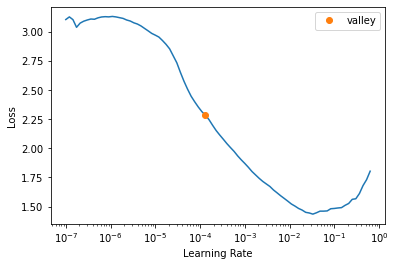

In [25]:
text_learner.lr_find()

In [27]:
text_learner.fit(2)

epoch,train_loss,valid_loss,time
0,0.646679,0.572973,01:38
1,0.565832,0.560660,01:39


### Ideas that haven't worked

In [ ]:
train_DataLoader=DataLoader(dataset=ds_train,batch_size=8,shuffle=True,device='cpu')
eval_DataLoader=DataLoader(dataset=ds_eval,batch_size=8,shuffle=True,device='cpu')

In [ ]:
def collate_fn(batch):
    pdb.set_trace()
    batch_tok=data_collator(batch[0])
    return batch_tok[0]['input_ids'],batch_tok[0]['attention_masks'],batch_tok[0]['token_type_ids'],batch[1]

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]